In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import csgraph
from scipy import linalg
from pysheds.grid import Grid
from scipy import ndimage
from matplotlib import colors
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
sns.set_palette('husl', 2)

In [3]:
grid = Grid.from_raster('../data/n30w100_dir',
                 data_name='dir', input_type='ascii')

In [4]:
grid.read_raster('../data/n30w100_con',
                 data_name='dem', input_type='ascii')

In [5]:
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')
# Clip the bounding box to the catchment
grid.clip_to('catch', precision=5)

grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

In [6]:
profiles, connections = grid.extract_profiles('catch', grid.acc > 25)

In [7]:
geom = grid.extract_river_network('catch', grid.acc > 25)

# Lo Diffusion + advection

In [8]:
dx = 60. * (np.asarray([profile.size for profile in profiles]) + 1)
n = max(max(connections.keys()), max(connections.values())) + 1
s = np.ones(n)
I = np.eye(n)
u = 1.0*np.ones(n)
D = (u * dx / 10).mean()*np.ones(n)
dt = 1
I[0, 0] = 0

U = np.zeros((n, n))
W = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    U[j, i] = u[i] * dt / dx[i]
    W[i, j] = u[i] * dt / dx[i]
    
V = np.diag(W @ s)

X = np.zeros((n, n))

for i, j in connections.items():
    X[i, j] = 2 / (dx[i] + dx[j])
    X[j, i] = 2 / (dx[i] + dx[j])
    
Y = np.diag(X @ s)

Z = np.diag(D * dt / dx)
S = (U - V) - Z @ (Y - X) + I

In [9]:
(u * dx / D).mean()

10.0

In [10]:
np.imag(np.linalg.eig(S)[0]).max(), np.imag(np.linalg.eig(S)[0]).min(), np.real(np.linalg.eig(S)[0]).max(), np.real(np.linalg.eig(S)[0]).min()

(0.0, 0.0, 0.9997196165216538, -0.0027755206889173286)

In [11]:
C = np.eye(n)

In [12]:
W_os = []
for i in range(len(S)):
    W_o_i = linalg.solve_discrete_lyapunov(S.T, I[[i]].T @ I[[i]])
    W_os.append(W_o_i)

In [13]:
Ws = []
ss = []
ns = 11

for i in range(ns):
    rs = np.asarray([np.linalg.matrix_rank(w + sum(Ws)) for w in W_os])
    ix = np.argmax(rs)
    ss.append(ix)
    Ws.append(W_os[ix])

In [14]:
W_c = linalg.solve_discrete_lyapunov(S, I)
st = np.argsort(np.diag(W_c))[::-1][:ns]

In [15]:
Adj = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    Adj[j, i] = 1
    Adj[i, j] = 1
    
Lap = sparse.csgraph.laplacian(Adj)

In [16]:
L, U = np.linalg.eigh(Lap)

In [17]:
np.random.seed(0)
trials = 200

T = np.random.choice(len(U), size=trials, replace=False)
ghat = [np.exp(np.minimum((100*np.random.randn() - 100), -1)*L) for _ in range(trials)]

In [18]:
X0 = np.vstack([(U @ np.diag(ghat[i]) @ U[T[i]]).ravel() for i in range(trials)])

In [19]:
X0 = X0 / np.linalg.norm(X0, axis=1).reshape(-1, 1)

In [20]:
x0 = X0[0]

In [21]:
C = np.eye(S.shape[0])[ss]
Ac = np.eye(S.shape[0])
Wo_r = np.zeros(S.shape)
R_r = np.zeros(x0.shape)
ys_r = []

for i in range(3600):
    y = C @ Ac @ x0
    ys_r.append(y)
    Wo_r += (Ac.T @ C.T @ C @ Ac)
    R_r += (Ac.T @ C.T @ ys_r[i])
    Ac = S @ Ac

In [22]:
x0_hat_r = (np.linalg.pinv(Wo_r) @ R_r).ravel()
x0 = x0.ravel()

In [23]:
((x0_hat_r - x0.ravel())**2).sum() / len(x0)

3.365466593356089e-05

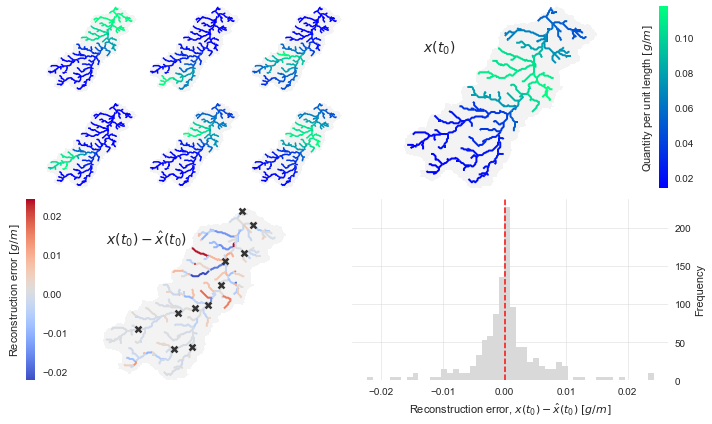

In [24]:
fig = plt.figure(figsize=(10,6))
spec = fig.add_gridspec(ncols=8, nrows=4, width_ratios=[0.1, 1, 1, 1, 1, 1, 1, 0.1])

ax = []
ax.append(fig.add_subplot(spec[0, 1]))
ax.append(fig.add_subplot(spec[0, 2]))
ax.append(fig.add_subplot(spec[0, 3]))
ax.append(fig.add_subplot(spec[1, 1]))
ax.append(fig.add_subplot(spec[1, 2]))
ax.append(fig.add_subplot(spec[1, 3]))
ax.append(fig.add_subplot(spec[0:2, 4:7]))
ax.append(fig.add_subplot(spec[2:4, 1:4]))
ax.append(fig.add_subplot(spec[2:4, 4:8]))
ax.append(fig.add_subplot(spec[0:2, 7]))
ax.append(fig.add_subplot(spec[2:4, 0]))

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom['features']]

for i in range(len(ax) - 3):
    ax[i].set_facecolor('w')
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])
    
sel = [6, 1, 3, 2, 8, 0]

for i in range(6):
    ax[i].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
                      vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
    mag = X0[sel[i]]
    norm = matplotlib.colors.Normalize(vmin=mag.min(), vmax=mag.max())
    mapper = cm.ScalarMappable(norm=norm, cmap='winter')
    colors = mapper.to_rgba(mag)
    line_segments = LineCollection(segs, colors=colors, linewidths=1.5)
    im = ax[i].add_collection(line_segments)
    ax[i].autoscale()
    
ax[6].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0
norm = matplotlib.colors.Normalize(vmin=x0.min(), vmax=x0.max())
mapper = cm.ScalarMappable(norm=norm, cmap='winter')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[6].add_collection(line_segments)
ax[6].autoscale()
ax[6].annotate('$x(t_0)$', (0.10, 0.75), xycoords='axes fraction', size=14)

ax[7].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0 - x0_hat_r
lmag = np.log10(mag + 1)
err_norm = matplotlib.colors.Normalize(vmin=mag.min(), vmax=mag.max())
mapper = cm.ScalarMappable(norm=err_norm, cmap='coolwarm')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[7].add_collection(line_segments)
ax[7].autoscale()
ax[7].annotate('$x(t_0) - \hat{x}(t_0)$', (0.02, 0.75), xycoords='axes fraction', size=14)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in ss])
ax[7].scatter(coords[:,0], coords[:,1], zorder=2,
                   marker='x', c='0.2', s=35, edgecolor='0.1', linewidth=2.5)

ax[8].set_facecolor('w')
ax[8].hist(x0 - x0_hat_r, density=True, bins=50, facecolor='0.85', histtype='stepfilled')
ax[8].axvline(0, c='r', linestyle='--', linewidth=1.5, alpha=0.95)
ax[8].set_xlabel('Reconstruction error, $x(t_0) - \hat{x}(t_0)$ $[g/m]$')
ax[8].set_ylabel('Frequency')
ax[8].yaxis.set_ticks_position('right')
ax[8].yaxis.set_label_position('right')
ax[8].grid(c='0.85', alpha=0.5)

cb1 = matplotlib.colorbar.ColorbarBase(ax[-1], cmap='coolwarm',
                                norm=err_norm,
                                orientation='vertical', label='Reconstruction error $[g/m]$')

cb1 = matplotlib.colorbar.ColorbarBase(ax[-2], cmap='winter',
                                norm=norm,
                                orientation='vertical', label='Quantity per unit length $[g/m]$')

ax[-2].yaxis.set_label_position('left')
ax[-1].yaxis.set_label_position('left')

plt.tight_layout()
plt.savefig('reconstruction_overview_edits.png', bbox_inches='tight', dpi=200)